#                                                                           Toxic Comments detector 

In [2]:
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
# nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
import json
import nltk
from flask import Flask, render_template, request,jsonify
import numpy as np
import random
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd


In [3]:

df_train=pd.read_excel("c:\\Users\\DNCCR\\Music\\final.xlsx")
df_train=df_train[['comment_text','target']]

## Affichage des dix premiers point du dataset 

In [7]:
df_train.head(10)

comment_text  target
0       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK       1
1  Hey... what is it..\n@ | talk .\nWhat is it......       1
2  Bye! \n\nDon't look, come or think of comming ...       1
3  You are gay or antisemmitian? \n\nArchangel WH...       1
4           FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!       1
5  I'm Sorry \n\nI'm sorry I screwed around with ...       1
6  GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK T...       1
7  Stupid peace of shit stop deleting my stuff as...       1
8  My Band Page's deletion. You thought I was gon...       1
9  Why can't you believe how fat Artie is? Did yo...       1

## Affichage des dix derniers points du dataset 

In [8]:
df_train.tail(10)

comment_text  target
25989  Unspecified source for Image:Fear_replica.jpg\...       0
25990  "user and talk pages, and their subpages, and ...       0
25991  The user also mentions that their preference, ...       0
25992  Edit-Warring on Camouflage articles\n\nWe are ...       0
25993  You are quite right that it is *usually* the u...       0
25994  "\nThe game theory is referenced. The lede nee...       0
25995  Do not ever message me \nI have thousands of V...       0
25996                    s been reverted to the original       0
25997  Have you considered putting your details onto ...       0
25998  "\n\n A cup of coffee for you! \n\n  I love co...       0

## On va faire la somme des points de données pour chaque classe, ici pour tester si on notre jeux de données est équilibrés ou non

In [14]:
df_train['target'].value_counts()

1    16224
0     9775
Name: target, dtype: int64

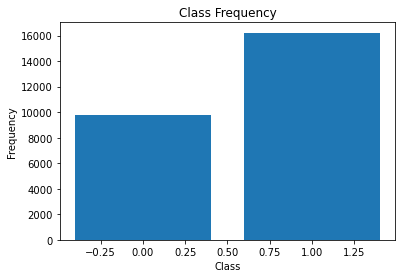

In [4]:
import matplotlib.pyplot as plt

classes = df_train['target'].values
unique, counts = np.unique(classes, return_counts=True)

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

#### Ici l'état de notre jeux de données est idéale ,nous allons nous concentrer surtout sur le message toxique donc nous avons besoin de plus de poits de données pour la classe 'toxic'

# Word analysis

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

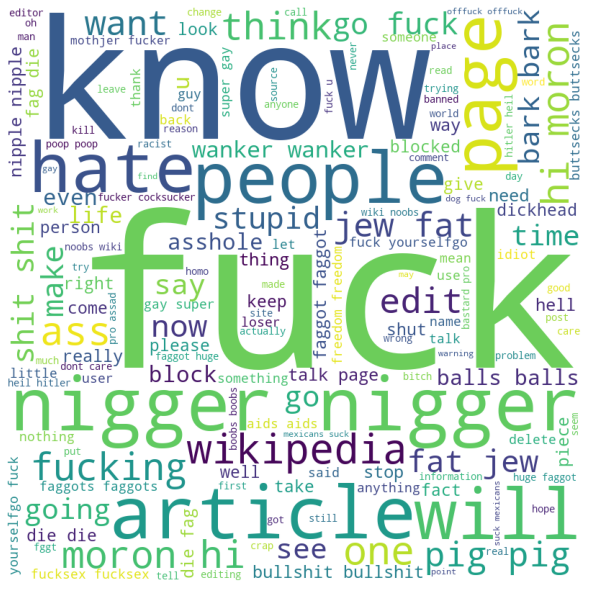

In [17]:
  
comment_words = '' 
stopwords = set(STOPWORDS) 
toxic=df_train[df_train['target']==1]
# iterate through the csv file 
for val in toxic.comment_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

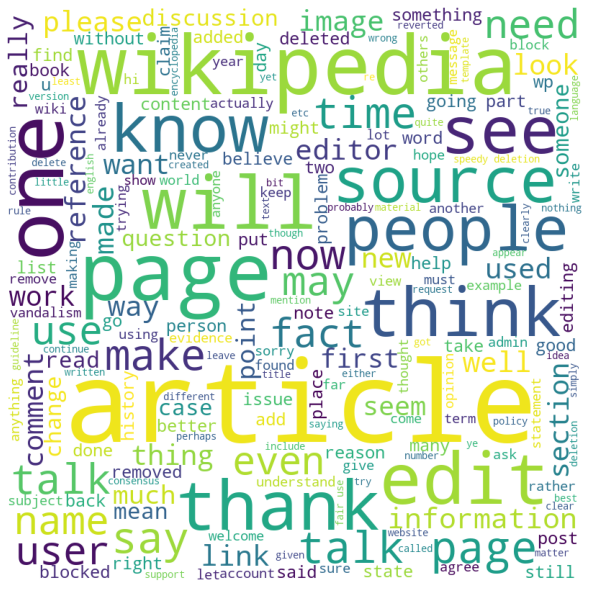

In [18]:
  
comment_words = '' 
stopwords = set(STOPWORDS) 
nottoxic=df_train[df_train['target']==0]
# iterate through the csv file 
for val in nottoxic.comment_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Data preparation

In [23]:
print(df_train.head(),df_train.tail(),sep='\n \n ')

                                        comment_text  target
0       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK       1
1  Hey... what is it..\n@ | talk .\nWhat is it......       1
2  Bye! \n\nDon't look, come or think of comming ...       1
3  You are gay or antisemmitian? \n\nArchangel WH...       1
4           FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!       1
 
                                             comment_text  target
25994  "\nThe game theory is referenced. The lede nee...       0
25995  Do not ever message me \nI have thousands of V...       0
25996                    s been reverted to the original       0
25997  Have you considered putting your details onto ...       0
25998  "\n\n A cup of coffee for you! \n\n  I love co...       0


# 1.  data cleaning
  * removing stopwords
  * removing punctuations and special chars
  * Stemming and lemmetization



In [27]:
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words= set(stopwords.words("english"))
new_words = ["using", "show", "result", "large",'by','year','university','experience','an','intern','phone', "also",'en','on','ma','un','une','moins','de','la','le','et','du','de','les','des', "if", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [28]:
corpus = []
def clean(df,corpus):
    for i in range(0, len(df)):
        #Remove punctuations
        text = re.sub('[^a-zA-Z]',' ', str(df['comment_text'][i]))

        
        #Convert to lowercase
        text = text.lower()
        
        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
        
        # remove special characters and digits
        text=re.sub("(\\d+|\\W)+"," ",text)
        
        ##Convert to list from string
        text = text.split()
        
        ##Stemming
        ps=PorterStemmer()
#        Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        corpus.append(text)
clean(df_train,corpus)



### Avant nétoyage

In [32]:
print(df_train['comment_text'][0])

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK


### Après nétoyage

In [31]:
print(corpus[0])

cocksucker piss around work


# 2. Vectorisation des données

### TF-IDF

In [37]:
tfidf = TfidfVectorizer(min_df=2,max_df=0.5,ngram_range=(1,1) , max_features=1000)    


In [38]:
features = tfidf.fit_transform(corpus)

In [39]:
dd=pd.DataFrame(features.todense(),columns=tfidf.get_feature_names())


In [36]:
dd.head()

able  absolutely  abuse  abusing  accept  according  account  accurate  \
0   0.0         0.0    0.0      0.0     0.0        0.0      0.0       0.0   
1   0.0         0.0    0.0      0.0     0.0        0.0      0.0       0.0   
2   0.0         0.0    0.0      0.0     0.0        0.0      0.0       0.0   
3   0.0         0.0    0.0      0.0     0.0        0.0      0.0       0.0   
4   0.0         0.0    0.0      0.0     0.0        0.0      0.0       0.0   

   accusation  act  ...  wrote  www   ya  yeah  year  yes  yet   yo  \
0         0.0  0.0  ...    0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   
1         0.0  0.0  ...    0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   
2         0.0  0.0  ...    0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   
3         0.0  0.0  ...    0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   
4         0.0  0.0  ...    0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   

   yourselfgo  yourselfgo fuck  
0         0.0              0.0  
1         0.0              0.0  
2         0.0              0.0  
3         0.0              0.0  
4         0.0              0.0  

[5 rows x 1000 columns]

## Train/Test Split

In [45]:
dd['TARGET']=df_train['target']
label=dd['TARGET']
Data=dd.drop(['TARGET'],axis=1)

In [46]:
xtrain,xtest,ytrain,ytest = train_test_split(Data,label,test_size=0.33) 

# 3. Modélisation

# Logistic regression

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver='liblinear', penalty='l1')


In [54]:
model.fit(xtrain, ytrain)


LogisticRegression(penalty='l1', solver='liblinear')

In [55]:
pred = model.predict(xtest)


In [56]:
accuracy_score(ytest,pred)

0.8786713286713287

In [58]:
from sklearn.metrics import classification_report
target_names = ['toxic', 'not toxic']
print(classification_report(ytest, pred, target_names=target_names))


              precision    recall  f1-score   support

       toxic       0.81      0.88      0.85      3227
   not toxic       0.92      0.88      0.90      5353

    accuracy                           0.88      8580
   macro avg       0.87      0.88      0.87      8580
weighted avg       0.88      0.88      0.88      8580



# Xgboost

In [79]:
from xgboost import XGBClassifier
from sklearn.model_selection import *
from sklearn.model_selection import GridSearchCV
xgb = XGBClassifier(learning_rate=0.002, n_estimators=600, objective='binary:logistic',silent=True, nthread=1,gamma=0.5,max_depth=2)






In [80]:

xgb.fit(xtrain, ytrain)
# make predictions for test data


C:\Users\DNCCR\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:26:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:26:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.002, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [81]:
y_pred = model.predict(xtest)
predictions = [(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.87%


In [82]:
print(classification_report(ytest, predictions, target_names=target_names))


              precision    recall  f1-score   support

       toxic       0.81      0.88      0.85      3227
   not toxic       0.92      0.88      0.90      5353

    accuracy                           0.88      8580
   macro avg       0.87      0.88      0.87      8580
weighted avg       0.88      0.88      0.88      8580

